# 🤖 Mobile robots project - Team 30

<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 15px; background-color: #E8F5E9; color: #333;">
    <strong>Course:</strong> <span>Basics of Mobile Robotics</span>
    <br><br>
    <strong>Professor:</strong> <span>Francesco Mondada</span>
    <br><br>
    <strong>T30 members:</strong>
    <ul>
        <li><strong>Name:</strong> Jiwon You, <strong>SCIPER:</strong></li>
        <li><strong>Name:</strong> Adriana Nancy Orellana Torrico, <strong>SCIPER:</strong> 376792</li>
        <li><strong>Name:</strong> Charles Froessel, <strong>SCIPER:</strong></li>
        <li><strong>Name:</strong> Johann Lugon-Moulin, <strong>SCIPER:</strong></li>
    </ul>
</div>



-------

# 📖 Project description

In this project, we are going to apply the concepts learned in the Basics of Mobile Robotics course to implement a system with multiple components, including vision, global navigation, local navigation, filtering, and motion control. Our goal is to enable a Thymio robot to navigate through an environment with a map, obstacles, and a goal point, while avoiding potential obstacles that may appear in its path and using motion estimation to improve its localization.

The system begins by detecting the map, obstacles, and goal point using a vision component, which also tracks the Thymio's position in real-time. The global navigation component then uses this information to plan the best path to the goal. Once the global path is computed, the local navigation component guides the Thymio along the path, and if new obstacles appear, the Thymio avoids them and returns to the original path.

In the following sections, we will describe the environment and components of our system in more detail. We will also present the results of our project in various scenarios, including static obstacles (2D shapes), dynamic obstacles (a 3D box), and "kidnapping" scenarios where the Thymio is moved to a different location on the map and must recompute a path to the goal.

## 1. Environment

For the environment we made the following choices:

- **Map:** Our map consists of nine A3-sized white paper sheets (297mm x 420mm each) joined together, resulting in a map size of 84.5 cm x 59.4 cm. We placed ArUco markers at the corners to facilitate map detection by the vision component.
- **Static obstacles:** We created various black paper polygons and placed them at different locations on the map.
- **Dynamic obstacles:** We used a square box as a dynamic obstacle that can appear along the path, and the Thymio must navigate around it.
- **Goal:** The goal is represented by a black circle on the map, which the Thymio must reach.

Below you can see an image of the environment we created:

<div style="text-align: center; margin-top:20px;">
    <strong>Environment captured by the camera</strong>
</div>
<div style="text-align: center; margin-top:20px;">
    <img src='./assets/report/environment.png' width='500'>
</div>

## 2. Components

### 2.1. Vision

**Responsible:** Adriana Nancy Orellana Torrico

The vision component is the responsible to take frames of the environment, preprocess them, and detect meaningful information. In this case, the map, its obstacles, the goal position and identify the thymio robot in real-time. To achieve this we use a camera AUKEY and the [openCV](https://opencv.org/) library. Our solution can be divided in the following steps:

1. Detect the map in the image.
2. Once the map is detected fix the perspective to have a top view of the map.
3. Identify the obstacles and the goal inside the map.
4. Detect the Thymio robot in real-time, providing its position and orientation.

#### Map detection

To detect the map, we first preprocess the image to remove any noise that might interfere with the detection. We use a bilateral filter to achieve this, which effectively removes noise while preserving the sharp edges of the map. Then, we use ArUco markers, which are binary patterns designed to be easily detectable in images and robust to changes in lighting. Each ArUco marker has a unique identifier, and thanks to OpenCV, we can obtain the x and y coordinates of each marker's four corners in clockwise order. To detect the map, we strategically placed four ArUco markers at each corner of the map. We use the following ArUco markers with the corresponding identifiers:

- **Top-left corner:** ArUco 2
- **Top-right corner:** ArUco 3
- **Bottom-right corner:** ArUco 4
- **Bottom-left corner:** ArUco 5

<div style="text-align: center; margin-top:20px;">
    <img src='./assets/map/marker_2.png' width='130'>
    <img src='./assets/map/marker_3.png' width='130'>
</div>
<div style="text-align: center;">
    <img src='./assets/map/marker_5.png' width='130'>
    <img src='./assets/map/marker_4.png' width='130'>
</div>
<div style="text-align: center; margin-top:20px;">
    <strong>Aruco markers with identifiers 2, 3 in the first row and 5, 4 in the second row</strong>
</div>

Once we detect these ArUco markers using OpenCV, we get the following corners of each marker:

- Top-left corner of ArUco 2
- Top-right corner of ArUco 3
- Bottom-right corner of ArUco 4
- Bottom-left corner of ArUco 5

With this data, we can correct the perspective of the map to obtain a top-down view, even if the camera is not positioned directly above the map. The following code shows the results of our map detection with perspective correction:

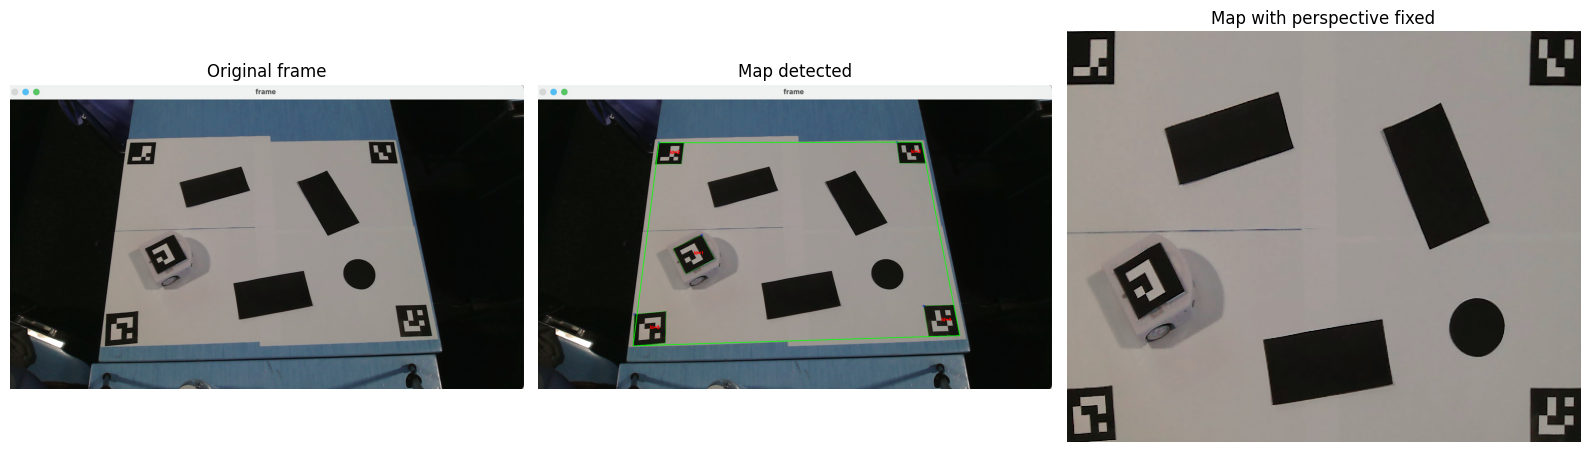

In [1]:
import cv2
import matplotlib.pyplot as plt

from src.cv import *

MAP_MAX_WIDTH = 500
MAP_MAX_HEIGHT = 400

frame = cv2.imread('./assets/report/environment.png')
frame_copy = frame.copy()

map_coords = detect_map(frame_copy, draw_arucos=True)

# Draw the border of the map
cv2.polylines(frame_copy, [map_coords.astype(np.int32)], True, (0, 255, 0), 2)

map_frame = fix_map_perspective(frame, map_coords, MAP_MAX_WIDTH, MAP_MAX_HEIGHT)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.imshow(frame)
plt.title('Original frame')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(frame_copy)
plt.title('Map detected')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(map_frame)
plt.title('Map with perspective fixed')
plt.axis('off')

plt.tight_layout()
plt.show()

#### Obstacle and goal detection

After identifying the map and correcting its perspective, we detect the obstacles and goal within it. To do this, we convert the image to grayscale and apply a Canny filter to detect the edges of all the elements inside the map. This helps us to identify the contours of the obstacles and goal.

We find the contours of all the elements inside the map, focusing only on the outer contours and removing redundant points to approximate them to simple shapes with vertices. For example, when we apply this process to a rectangle, we end up with four points that represent its corners. On the other hand, when we approximate the contour of a circle, we get more than 10 points. To account for this, we set a threshold of 10 points to determine whether a contour is a circle or not. If it has more than 10 points, we consider it a circle.

Once we have identified a circle, we calculate its circumference and center coordinates (x, y), which represent the goal's location. In the case of obstacles, we need to expand their contours to prevent the Thymio from passing through them.

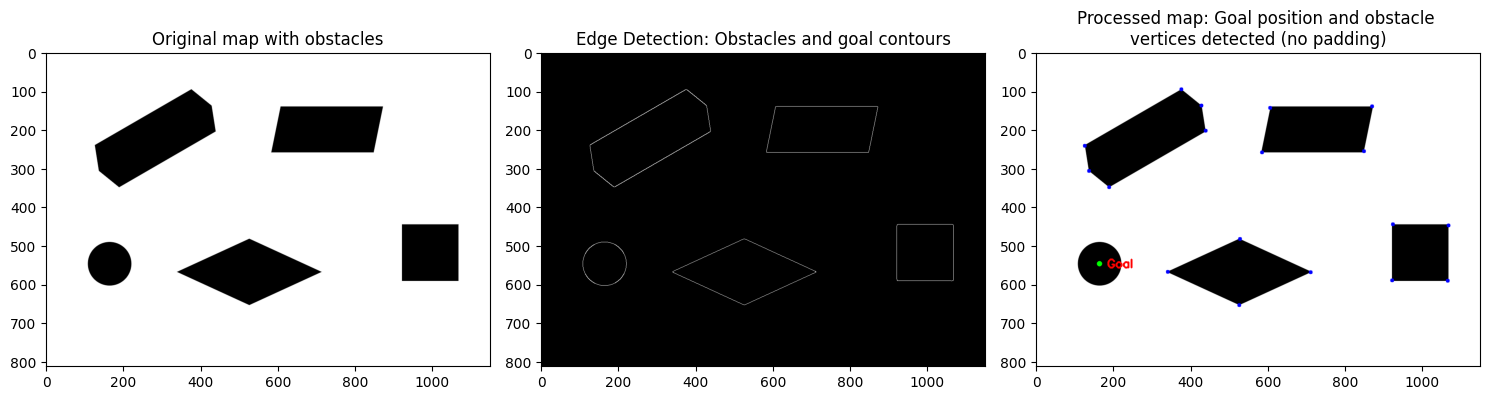

In [17]:
from matplotlib import pyplot as plt
from src.cv import *

map_with_obstacles = cv2.imread('./assets/report/obstacles.png')
map_with_obstacles_copy = map_with_obstacles.copy()

canny_img = preprocess_obstacles(map_with_obstacles)
obstacles_contours, _, goal_coords = detect_obstacles_and_goal(map_with_obstacles, 0)

draw_obstacles(map_with_obstacles_copy, obstacles_contours)
draw_goal(map_with_obstacles_copy, goal_coords)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(map_with_obstacles)
plt.title('Original map with obstacles')

plt.subplot(1, 3, 2)
plt.imshow(canny_img, cmap='gray')
plt.title('Edge Detection: Obstacles and goal contours')

plt.subplot(1, 3, 3)
plt.imshow(map_with_obstacles_copy)
plt.title('Processed map: Goal position and obstacle \nvertices detected (no padding)')

plt.tight_layout()
plt.show()

### Obstacle expansion

To prevent the Thymio from entering any obstacles, we expand them by adding a padding around their contours. This padding is computed for each contour, taking into account the center of the obstacle and the direction from the center to each vertex. We calculate a unit vector from the center to each vertex, which represents the direction in which the padding should be expanded. We then multiply this unit vector by the padding value and add it to the vertex. This results in new vertices that represent the expanded obstacle.

Below is an example of obstacle expansion:

<div style="text-align: center; margin-top:20px;">
    <img src='./assets/report/obstacle_expansion1.png' width='370'>
    <img src='./assets/report/obstacle_expansion2.png' width='400'>
</div>
<div style="text-align: center; margin-top:20px;">
    <strong>Obstacle Expansion</strong>
    <p style="font-size: 14px; color: #666;">Original vertices (left) vs. expanded vertices (right)</p>
    <p style="font-size: 14px; color: #666;"><strong>Note:</strong> The arrows next to x and y illustrate the direction of expansion for each vertex.</p>
</div>

Our algorithm also returns a mask of the expanded obstacles, which we use to build the visibility graph described in the global navigation section. The following code cell shows the result of our obstacle expansion:

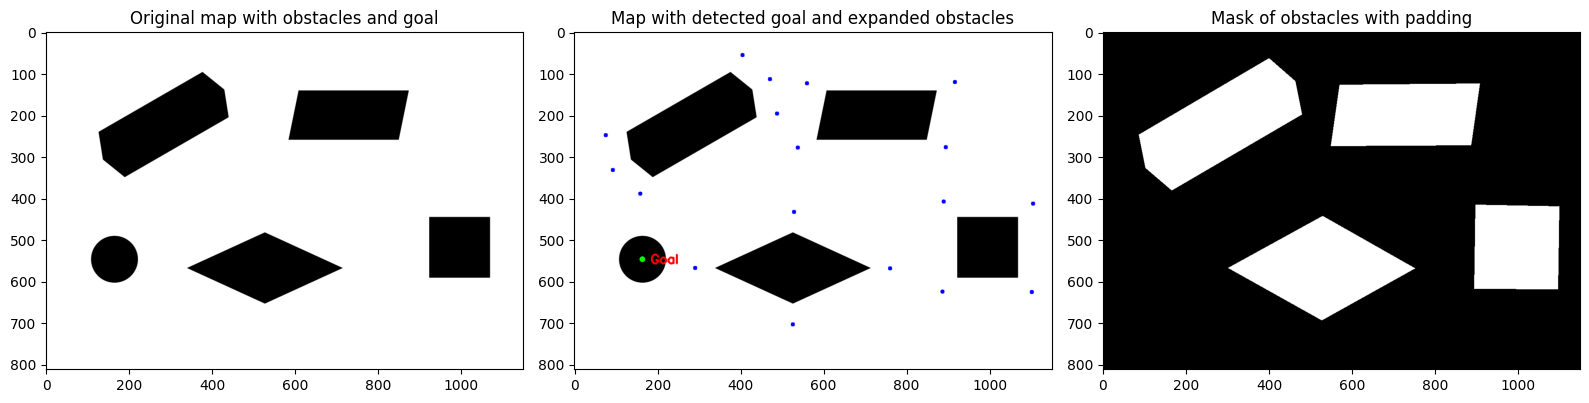

In [21]:
from matplotlib import pyplot as plt
from src.cv import *

PADDING_OBSTACLES = 50

map_with_obstacles = cv2.imread('./assets/report/obstacles.png')
map_with_obstacles_copy = map_with_obstacles.copy()

obstacles_contours, mask_obstacles, goal_coords = detect_obstacles_and_goal(map_with_obstacles, PADDING_OBSTACLES)
draw_obstacles(map_with_obstacles_copy, obstacles_contours)
draw_goal(map_with_obstacles_copy, goal_coords)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.imshow(map_with_obstacles)
plt.title('Original map with obstacles and goal')

plt.subplot(1, 3, 2)
plt.imshow(map_with_obstacles_copy, cmap='gray')
plt.title('Map with detected goal and expanded obstacles')

plt.subplot(1, 3, 3)
plt.imshow(mask_obstacles)
plt.title('Mask of obstacles with padding')

plt.tight_layout()
plt.show()

#### Thymio detection

We use an ArUco marker with the identifier 1 to detect the Thymio robot. This marker is attached to the top of the Thymio robot and is detected in every frame. By getting its 4 corners, we determine the position and orientation of the marker, which are then used by the Kalman filter to estimate the Thymio's position and orientation.

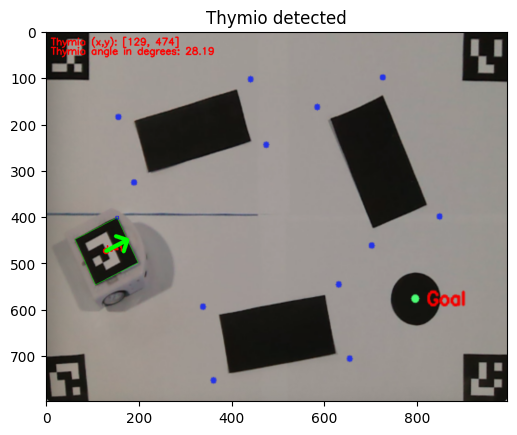

In [4]:
from matplotlib import pyplot as plt
from src.cv import *

frame_with_thymio = cv2.imread('./assets/report/map-cv.png')

thymio_coords = detect_thymio(frame_with_thymio, draw_aruco=True)

plt.imshow(frame_with_thymio)
plt.title('Thymio detected')
plt.show()

### 2.2. Path planning

**Responsible:** Charles Froessel

**Slides intructions:** The objective is that the Thymio goes from an arbitrary position in the map to a target that can be placed anywhere in the environment. These will be changed during the demo to see how your system performs. (remove when completed) 

**Link for schematics (Use epfl account):** https://epflch-my.sharepoint.com/:p:/r/personal/charles_froessel_epfl_ch/_layouts/15/doc.aspx?sourcedoc=%7B20d9373d-95f6-4339-9879-352d763cab56%7D&action=edit 

### 2.3. Motion control and pose estimation

**Responsible:** Jiwon You

**Slides intructions:** You will have to control the robot to help it move along the path. This requires an accurate estimate of the position of the robot which you will have to obtain through bayesian filtering. (remove when completed)

### 2.4. Obstacle avoidance

**Responsible:** Johann Lugon-Moulin

**Slides intructions:** While navigating, the Thymio will have to use local navigation to avoid physical obstacles that can be put in its path at any point in time. You are free to choose what these physical objects are. (remove when completed)

## 3. 💻 Running the project

Before running the project please ensure you have the following dependencies installed:

- `opencv-python`
- `numpy`
- `matplotlib`
- `opencv-python`
- `opencv-contrib-python`

Or run the following command to install them:

```bash
pip install -r requirements.txt
```

Then, to run the project you can run the following command:

```bash
python src/main.py
```

Or run the following cell:

## 4. 📍 Conclusion

## 5. 📁 References

1. **Detecting aruco markers with OpenCV and Python:** https://www.geeksforgeeks.org/detecting-aruco-markers-with-opencv-and-python-1/
2. **Aruco marker detection:** https://docs.opencv.org/3.4/d9/d6d/tutorial_table_of_content_aruco.html#:~:text=ArUco%20markers%20are%20binary%20square,pose%20estimation%20and%20camera%20calibration.
2. **OpenCV documentation for image processing:** https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
3. **Aruco marker angle calculation:** https://github.com/anish-natekar/OpenCV_ArUco_Angle_Estimation/blob/main/aruco_library.py
4. **Detect shapes in images:** https://www.geeksforgeeks.org/how-to-detect-shapes-in-images-in-python-using-opencv/
5. **Contour feaures:** https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
5. **Copilot:** https://copilot.github.com/
6. **ChatGPT:** https://chatgpt.com/
